In [78]:
# ECE661 HW8
# Zhengxin Jiang
# jiang839

import cv2
import numpy as np
import matplotlib . pyplot as plt
import math
from scipy.optimize import least_squares


# load the whole image set
def loadImages(prefix, num):
    
    imgset = []
    
    for idx in range(1, num+1):
        img = cv2.imread('Dataset1/'+prefix+str(idx)+'.jpg')
        imgset.append(img)
        
    return imgset

def loadSelfImages(num):
    
    imgset = []
    
    for idx in range(num):
        img = cv2.imread('Dataset2/'+str(idx)+'.jpg')
        imgset.append(img)
        
    return imgset

# The function takes two arrays of points and return the homography from 1 to 2
def findHomograpy_LeastSquare(points_1, points_2):
    
    P = np.zeros((len(points_1)*2+1, 9))
    
    # construct a homogenious system
    for i in range(len(points_1)):
        
        P[2*i, 0] = -points_1[i][0]
        P[2*i, 1] = -points_1[i][1]
        P[2*i, 2] = -1
        P[2*i, 6] = points_1[i][0]*points_2[i][0]
        P[2*i, 7] = points_1[i][1]*points_2[i][0]
        P[2*i, 8] = points_2[i][0]
        
        P[2*i+1, 3] = -points_1[i][0]
        P[2*i+1, 4] = -points_1[i][1]
        P[2*i+1, 5] = -1
        P[2*i+1, 6] = points_1[i][0]*points_2[i][1]
        P[2*i+1, 7] = points_1[i][1]*points_2[i][1]
        P[2*i+1, 8] = points_2[i][1]
    
    P[-1, -1] = 1
    
    b = np.zeros(len(points_1)*2+1)
    b[-1] = 1     
    
    # solving H using least square method
    H = np.linalg.lstsq(P, b, rcond=None)[0]
    H = H/H[-1]
    H = np.reshape(H, (3,3))
    
    return H


# given a rho-sorted line set, return the filtered lines
def lineFilter(lines, thresh):
    
    lines_filtered = []
    group = []
    
    for i in range(len(lines)):
        
        if i == 0:
            group.append(lines[i])
        elif (abs(lines[i][0] - lines[i-1][0])) < thresh:
            group.append(lines[i])
        else:
            lines_filtered.append(np.mean(group, axis=0))
            group = []
            group.append(lines[i])
            
    lines_filtered.append(np.mean(group, axis=0))

    return np.array(lines_filtered)


# convert lines to points on the line
def lineToPoint(lines):
    
    p1, p2 = [], []
    
    for rho,theta in lines:
    
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 - 1000*(-b))
        y1 = int(y0 - 1000*(a))
        x2 = int(x0 + 1000*(-b))
        y2 = int(y0 + 1000*(a))
        
        p1.append((x1, y1))
        p2.append((x2, y2))
    
    return np.array(p1), np.array(p2)


# find the intersection points
def findIntersections(vp1, vp2, hp1, hp2):
    
    intersects = []
    
    vp1 = np.append(vp1, np.ones((len(vp1),1)), axis=1)
    vp2 = np.append(vp2, np.ones((len(vp2),1)), axis=1)
    hp1 = np.append(hp1, np.ones((len(hp1),1)), axis=1)
    hp2 = np.append(hp2, np.ones((len(hp2),1)), axis=1) 
    
    vlines=np.cross(vp1,vp2)
    hlines=np.cross(hp1,hp2)

    for hline in hlines:
        
        its_temp = np.cross(vlines, hline)
        its_temp = (its_temp.T/its_temp.T[-1]).T.astype(int)
        
        intersects.append(its_temp)
        
    intersects = np.concatenate(intersects,axis=0)
    
    return intersects


# find the intersection points in an image
def intersectionsInImage(image, outputLinePoints=False):
    
    img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # extract edges and lines
    edges = cv2.Canny(img,255,400)
    lines = np.squeeze(cv2.HoughLines(edges, 1, np.pi/180, 50))
    
    # line filter
    vlines = lines[np.where(abs(lines[:,1]-np.pi/2)>(np.pi/4) )]
    for i in range(len(vlines)):  # dealing with nearly vertical/horizontal lines
        if vlines[i][0]<0 and abs(vlines[i][1]-np.pi)<0.2:
            vlines[i][0] = abs(vlines[i][0])
            vlines[i][1] -= np.pi
    vlines = np.array(sorted(vlines, key=lambda x: x[0]))
    vlines = lineFilter(vlines, 10)
    if (vlines[:,0]<0).all():   # maintain the correct intersection points order
        vlines = np.array(sorted(vlines, key=lambda x: abs(x[0])))
    
    hlines = lines[np.where(abs(lines[:,1]-np.pi/2)<(np.pi/4) )]
    for i in range(len(hlines)):
        if hlines[i][0]<0 and abs(hlines[i][1]-np.pi)<0.2:
            hlines[i][0] = abs(hlines[i][0])
            hlines[i][1] -= np.pi
    hlines = np.array(sorted(hlines, key=lambda x: x[0]))
    hlines = lineFilter(hlines, 10)
    if (hlines[:,0]<0).all():
        hlines = np.array(sorted(hlines, key=lambda x: abs(x[0])))
    
    vp1, vp2 = lineToPoint(vlines)
    hp1, hp2 = lineToPoint(hlines)

    # calculate intersections
    intersects = findIntersections(vp1, vp2, hp1, hp2)
    
    if outputLinePoints:
        return intersects, vp1, vp2, hp1, hp2
    else:
        return intersects
    

# Find the intrinsic and extrinsic parameters of an image set
def findParameters(imgset, world_coords):
    
    # caluculate the per-image homographies
    H_list = []
    validimg_indices = []
    intersects_list = []

    for i in range(len(imgset)):
        intersects = intersectionsInImage(imgset[i])

        if len(intersects) == 80:
            H = findHomograpy_LeastSquare(world_coords, intersects)
            H_list.append(H)
            validimg_indices.append(i)
            intersects_list.append(intersects)
    
    # calculate omega
    num = len(H_list)
    V = np.zeros((num*2+1, 6))

    for i in range(num):

        H = H_list[i]

        V[i*2] = np.array([H[0,0]*H[0,1], H[0,0]*H[1,1]+H[1,0]*H[0,1], H[1,0]*H[1,1], 
                           H[2,0]*H[0,1]+H[0,0]*H[2,1], H[2,0]*H[1,1]+H[1,0]*H[2,1], H[2,0]*H[2,1] ])
        V[i*2+1] = np.array([(H[0,0]**2-H[0,1]**2), (H[0,0]*H[1,0]-H[0,1]*H[1,1])*2, (H[1,0]**2-H[1,1]**2), 
                           (H[0,0]*H[2,0]-H[0,1]*H[2,1])*2, (H[1,0]*H[2,0]-H[1,1]*H[2,1])*2, (H[2,0]**2-H[2,1]**2) ])

    V[-1, -1] = 1

    b = np.zeros(num*2+1)
    b[-1] = 1     

    omega = np.linalg.lstsq(V, b, rcond=None)[0]
    
    # calculate intrinsic parameters K
    y0 = (omega[1]*omega[3]-omega[0]*omega[4])/(omega[0]*omega[2]-omega[1]**2)
    lamda = omega[5]-(omega[3]**2+y0*(omega[1]*omega[3]-omega[0]*omega[4]))/omega[0]
    ax = np.sqrt(lamda/omega[0])
    ay = np.sqrt(lamda*omega[0]/(omega[0]*omega[2]-omega[1]**2))
    s = -omega[1]*ax**2*ay/lamda
    x0 = s*y0/ay - omega[3]*ax**2/lamda

    K = np.array([[ax, s, x0],[0, ay, y0],[0, 0, 1]])
    
    # calculate extrinsic parameters R and t
    R_list=[]
    t_list=[]

    for H in H_list:

        # K inverse multiply h, then apply scale factor
        temp = np.dot(np.linalg.inv(K),H)
        temp = temp/np.linalg.norm(temp[:,0])

        r3 = np.cross(temp[:,0], temp[:,1])
        t = temp[:,2].copy()

        temp[:,2] = r3

        # conditioning
        u, _, v = np.linalg.svd(temp)
        R = np.dot(u, v)

        R_list.append(R)
        t_list.append(t)
        
    return K, R_list, t_list, np.array(validimg_indices), intersects_list
    
  
    
# Do repeojection from a source image to destination image
def reprojection(source_img_num, dest_img_num, intersects_list, H_rep_list, validimg_indices):
    
    idx_s = np.where(validimg_indices==source_img_num-1)[0]
    idx_d = np.where(validimg_indices==dest_img_num-1)[0]
    
    if len(idx_s) == 1 and len(idx_d) == 1:
        
        spoints = intersects_list[idx_s[0]]
        
        Hs = H_rep_list[idx_s[0]]
        Hd = H_rep_list[idx_d[0]]
        
        H_sd = np.dot(Hd, np.linalg.inv(Hs))
        
        
    dpoints = np.dot(H_sd, spoints.T)
    dpoints = np.divide(dpoints, dpoints[-1]).T
    
    return dpoints.astype(int)

    

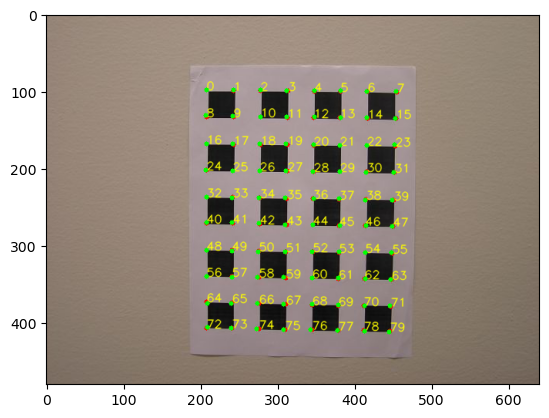

In [77]:
if __name__ == '__main__':
    
    result_path = 'C:/Users/jzx/OneDrive - purdue.edu/ECE661/hw8/result images/'
    
    # load image set
    imgset = loadImages('Pic_', 40)
    
    # image set with intersects labeled
    imgset_labeled = []

    for i in range(len(imgset)):
        
        img = imgset[i].copy()

        intersects = intersectionsInImage(img)
        intersects = intersects[:, :2]

        for i in range(len(intersects)):
            cv2.circle(img,tuple(intersects[i]),radius=3,color=(0,0,255),thickness=-1)
            cv2.putText(img,str(i),tuple(intersects[i]),cv2.FONT_HERSHEY_SIMPLEX,0.5, (0,255,255),1,cv2.LINE_AA)
    
        imgset_labeled.append(img)
        
    # create world coordinates for corner points
    h = np.linspace(0, 350, 8)
    v = np.linspace(0, 450, 10)

    world_coords = np.zeros((len(v)*len(h), 2))
    for i in range(len(world_coords)):
        world_coords[i] = [h[i%8], v[i//8]]
      
    # calculate parameters
    K, R_list, t_list, validimg_indices, intersects_list = findParameters(imgset, world_coords)  
    
    # calculate back project homographies from world coordinates to images
    H_back_list = []

    for i in range(len(R_list)):

        imgidx = validimg_indices[i]

        temp = R_list[i]
        temp[:,2] = t_list[i]

        H_back = np.dot(K, temp)
        H_back_list.append(H_back)
        
    # reproject to the fixed image
    fixed_img = 11
    rep_img = 1
    
    rep_points = reprojection(rep_img, fixed_img, intersects_list, H_back_list, validimg_indices)

    img_rep = imgset_labeled[fixed_img-1].copy()

    for i in rep_points:
        cv2.circle(img_rep,tuple(i[:2]),radius=3,color=(0,255,0),thickness=-1)

    cv2.imwrite(result_path + 'rep_1to11' + '.jpg', img_rep)    
        
    img_rep = cv2.cvtColor(img_rep, cv2.COLOR_BGR2RGB)
    plt.figure()
    plt.imshow(img_rep)    
    
    
    
    # self images
    

In [3]:
h = np.linspace(0, 350, 8)
v = np.linspace(0, 450, 10)

world_coords = np.zeros((len(v)*len(h), 2))
for i in range(len(world_coords)):
    world_coords[i] = [h[i%8], v[i//8]]
    
# print(len(world_coords))

In [5]:
validimgidx = []
H_list = []

for i in range(len(imgset)):
    intersects = intersectionsInImage(imgset[i])
    
    if len(intersects) == 80:
        validimgidx.append(i)
        
        H = findHomograpy_LeastSquare(world_coords, intersects)
        H_list.append((H,i))
        
print(validimgidx)  
print(len(validimgidx))
# print(H_list)
        
    

    

[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]
38


In [6]:
num = len(H_list)

V = np.zeros((num*2+1, 6))

for i in range(num):
    
    H = H_list[i][0]
    
    V[i*2] = np.array([H[0,0]*H[0,1], H[0,0]*H[1,1]+H[1,0]*H[0,1], H[1,0]*H[1,1], 
                       H[2,0]*H[0,1]+H[0,0]*H[2,1], H[2,0]*H[1,1]+H[1,0]*H[2,1], H[2,0]*H[2,1] ])
    
    V[i*2+1] = np.array([(H[0,0]**2-H[0,1]**2), (H[0,0]*H[1,0]-H[0,1]*H[1,1])*2, (H[1,0]**2-H[1,1]**2), 
                       (H[0,0]*H[2,0]-H[0,1]*H[2,1])*2, (H[1,0]*H[2,0]-H[1,1]*H[2,1])*2, (H[2,0]**2-H[2,1]**2) ])

V[-1, -1] = 1
    
b = np.zeros(num*2+1)
b[-1] = 1     

omega = np.linalg.lstsq(V, b, rcond=None)[0]
    
print(omega)    



[ 1.49020750e-06 -8.78711073e-10  1.50215240e-06 -4.77433246e-04
 -3.52509798e-04  1.00000000e+00]


In [57]:
y0 = (omega[1]*omega[3]-omega[0]*omega[4])/(omega[0]*omega[2]-omega[1]**2)
print(x0)
lamda = omega[5]-(omega[3]**2+x0*(omega[1]*omega[3]-omega[0]*omega[4]))/omega[0]
print(lamda)

ax = np.sqrt(lamda/omega[0])
ay = np.sqrt(lamda*omega[0]/(omega[0]*omega[2]-omega[1]**2))
s = -omega[1]*ax**2*ay/lamda
x0 = s*x0/ay - omega[3]*ax**2/lamda

K = np.array([[ax, s, x0],[0, ay, y0],[0, 0, 1]])

print(K)

234.8572894672579
0.7641841421412303
[[7.16103239e+02 4.20573051e-01 3.20518865e+02]
 [0.00000000e+00 7.13250504e+02 2.34857289e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


In [58]:
R_list=[]
t_list=[]

for H in H_list:
    
    # K inverse multiply h, then apply scale factor
    temp = np.dot(np.linalg.inv(K),H[0])
    temp = temp/np.linalg.norm(temp[:,0])
    
    r3 = np.cross(temp[:,0], temp[:,1])
    t = temp[:,2].copy()
    
    temp[:,2] = r3
    
    # conditioning
    u, _, v = np.linalg.svd(temp)
    R = np.dot(u, v)
    
    R_list.append(R)
    t_list.append(t)


# print(R_list)    
# print(t_list)
    


In [38]:
K, R_list, t_list, validimg_indices = findParameters(imgset, world_coords)

H_back_list = []

for i in range(len(R_list)):
    
    imgidx = validimg_indices[i]
    
    temp = R_list[i]
    temp[:,2] = t_list[i]
    
    H_back = np.dot(K, temp)
    
#     print(H_list[i])
#     print(H_back)
    
    H_back_list.append(H_back)
    

# print(R_list[0])
# print(t_list[0])

# temp = R_list[0]
# temp[:,2] = t_list[0]

# print(temp)


In [40]:
print(validimg_indices)
idx_s = np.where(validimg_indices==9)[0]
print(idx_s)

[ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
[]


In [21]:
wc = np.append(world_coords, np.ones((len(world_coords),1)), axis=1)

pback = np.dot(H_back_list[0], wc.T)
pback = np.divide(pback, pback[-1]).T

# print(pback)

# pback_ = np.dot(H_list[0][0], wc.T)
# pback_ = np.divide(pback_, pback_[-1]).T

# print(pback_)



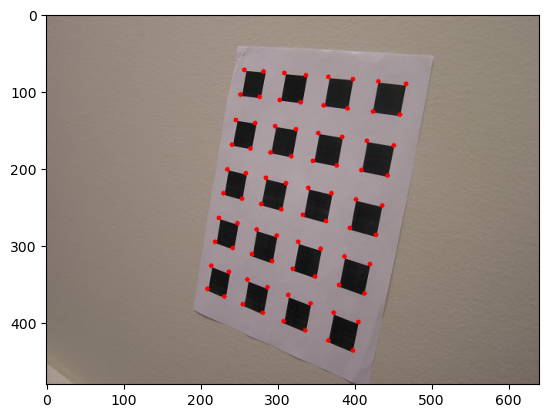

In [22]:
img = cv2.imread('Dataset1/Pic_1.jpg')
img_test = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

for i in pback:
    cv2.circle(img_test,tuple(i[:2].astype(int)),radius=3,color=(255,0,0),thickness=-1)
    
plt.figure()
plt.imshow(img_test)    


[[-147.           2.687807 ]
 [-116.           2.687807 ]
 [-177.           2.687807 ]
 [-292.           2.7052603]
 [-266.           2.7052603]
 [-318.           2.7052603]
 [-205.           2.687807 ]
 [-233.           2.687807 ]
 [-240.           2.7052603]
 [-213.           2.7052603]
 [-260.           2.687807 ]
 [-312.           2.687807 ]
 [-108.           2.6703537]
 [-286.           2.687807 ]
 [-152.           2.7052603]
 [-211.           2.7052603]
 [-184.           2.7052603]]
[[-147.           2.687807 ]
 [-116.           2.687807 ]
 [-177.           2.687807 ]
 [-292.           2.7052603]
 [-266.           2.7052603]
 [-318.           2.7052603]
 [-205.           2.687807 ]
 [-233.           2.687807 ]
 [-240.           2.7052603]
 [-213.           2.7052603]
 [-260.           2.687807 ]
 [-312.           2.687807 ]
 [-108.           2.6703537]
 [-286.           2.687807 ]
 [-152.           2.7052603]
 [-211.           2.7052603]
 [-184.           2.7052603]]
[[-318.     

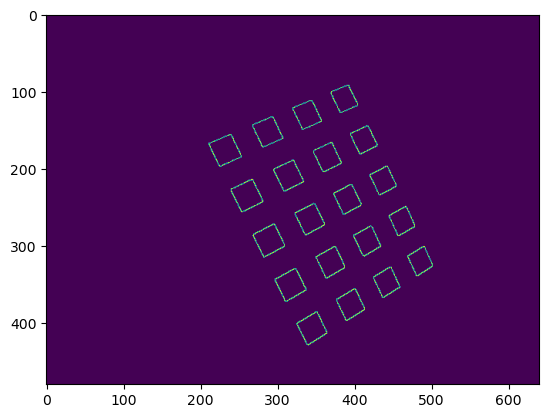

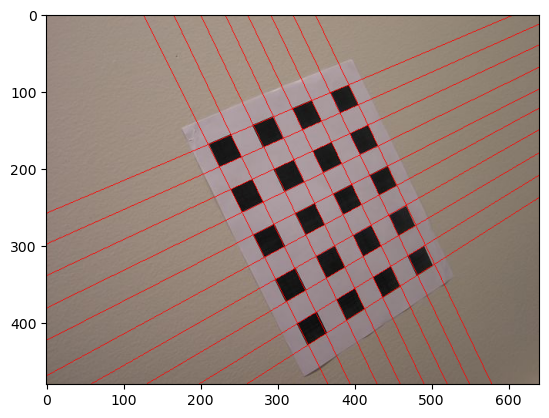

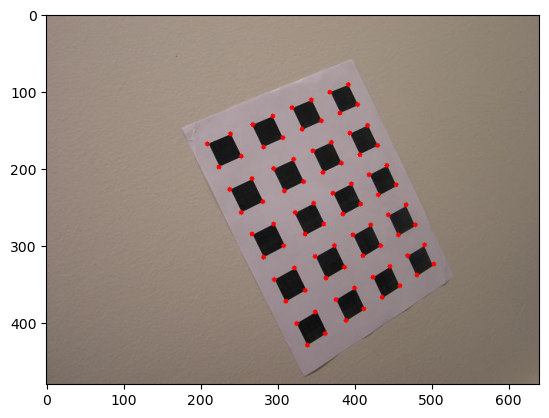

In [14]:
# extract edge

img = cv2.imread('Dataset1/Pic_4.jpg')
img_test = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_test2 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

edges = cv2.Canny(img,255,400)
plt.imshow(edges)

lines = np.squeeze(cv2.HoughLines(edges, 1, np.pi/180, 50))
# print(lines)

vlines = lines[np.where(abs(lines[:,1]-np.pi/2)>(np.pi/4) )]
print(vlines)
for i in range(len(vlines)):
    if vlines[i][0]<0 and abs(vlines[i][1]-np.pi)<0.15:
        vlines[i][0] = abs(vlines[i][0])
        vlines[i][1] -= np.pi
print(vlines)
vlines = np.array(sorted(vlines, key=lambda x: x[0]))
print(vlines)
vlines = lineFilter(vlines, 10)
print(vlines)
# vlines = np.array(sorted(vlines, key=lambda x: abs(x[0])))

hlines = lines[np.where(abs(lines[:,1]-np.pi/2)<(np.pi/4))]
print(hlines)
for i in range(len(hlines)):
    if hlines[i][0]<0 and abs(hlines[i][1]-np.pi)<0.15:
        hlines[i][0] = abs(hlines[i][0])
        hlines[i][1] -= np.pi
print(hlines)
hlines = np.array(sorted(hlines, key=lambda x: x[0]))
print(hlines)
hlines = lineFilter(hlines, 10)
print(hlines)

vp1, vp2 = lineToPoint(vlines)
hp1, hp2 = lineToPoint(hlines)

intersects = findIntersections(vp1, vp2, hp1, hp2)

# intersects, vp1, vp2, hp1, hp2 = intersectionsInImage(img, outputLinePoints=True)

for i in range(len(vp1)):
    cv2.line(img_test,tuple(vp1[i]),tuple(vp2[i]),(255,0,0),1)
    
for i in range(len(hp1)):
    cv2.line(img_test,tuple(hp1[i]),tuple(hp2[i]),(255,0,0),1)

intersects = intersects[:, :2]
for i in intersects:
    cv2.circle(img_test2,tuple(i),radius=3,color=(255,0,0),thickness=-1)
    
plt.figure()
plt.imshow(img_test)    

plt.figure()
plt.imshow(img_test2)   



    

In [ ]:
img = cv2.imread('Dataset1/Pic_3.jpg')
intersects = intersectionsInImage(img)



[[ 182  807]
 [ 190  807]
 [ 311  811]
 ...
 [1108 1996]
 [1082 1997]
 [1086 1997]]
580


True

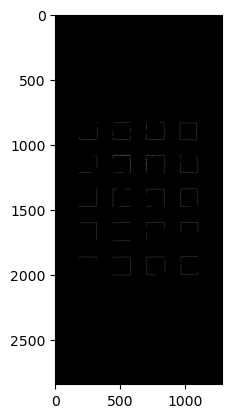

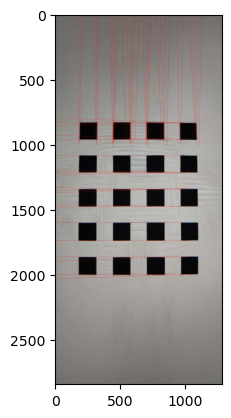

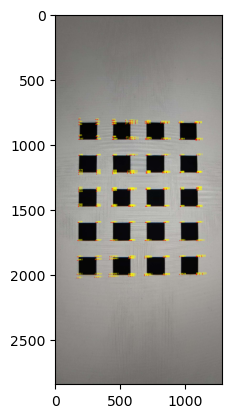

In [82]:
img = cv2.imread('Dataset2/0.jpg')
img_test = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_test2 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
intersects, vp1, vp2, hp1, hp2 = intersectionsInImage(img, outputLinePoints=True)
intersects = intersects[:, :2]
print(intersects)
print(len(intersects))

edges = cv2.Canny(img,300,400)
edges=cv2.cvtColor(edges, cv2.COLOR_BGR2RGB)
plt.imshow(edges)

for i in range(len(vp1)):
    cv2.line(img_test,tuple(vp1[i]),tuple(vp2[i]),(255,0,0),1)
    
for i in range(len(hp1)):
    cv2.line(img_test,tuple(hp1[i]),tuple(hp2[i]),(255,0,0),1)

intersects = intersects[:, :2]
for i in range(len(intersects)):
    cv2.circle(img_test2,tuple(intersects[i]),radius=3,color=(255,0,0),thickness=-1)
    cv2.putText(img_test2,str(i),tuple(intersects[i]),cv2.FONT_HERSHEY_SIMPLEX,0.5, (255,255,0),1,cv2.LINE_AA)
    
plt.figure()
plt.imshow(img_test)    

plt.figure()
plt.imshow(img_test2)

cv2.imwrite(result_path + 'edges_3' + '.jpg', edges)
img_test = cv2.cvtColor(img_test, cv2.COLOR_RGB2BGR)
img_test2 = cv2.cvtColor(img_test2, cv2.COLOR_RGB2BGR)
cv2.imwrite(result_path + 'lines_3' + '.jpg', img_test)
cv2.imwrite(result_path + 'intersects_3' + '.jpg', img_test2)




0.09983341664682815
